In [1]:
import math
from abc import abstractmethod

import numpy as np
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from einops import repeat


In [2]:
def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(
            x,
        )

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )#TODO:Mudar
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)#TODO: Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )#TODO:Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, 3, padding=1
            )#TODO:Mudar
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, 1)#TODO:Mudar

    def forward(self, x, emb):
        return self._forward(x, emb)

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

class UNetModel(nn.Module):
    def __init__(
        self,
        image_size=32,
        in_channels=1,
        model_channels=32,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=[16, 8],
        dropout=0.1,
        channel_mult=(2, 4, 8),
        num_heads=4,
        use_scale_shift_norm=False,
        resblock_updown=True,
    ):
        super().__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv1d(in_channels, model_channels, 3, padding=1))
        ])
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, use_scale_shift_norm=use_scale_shift_norm)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch, True, out_channels=out_ch)))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, use_scale_shift_norm=use_scale_shift_norm)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(Upsample(ch, True, out_channels=out_ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            Normalize(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(ch, out_channels, 3, padding=1)),
        )

    def forward(self, x, timesteps=None, context=None, y=None):
        assert timesteps is not None, "timesteps must be provided"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        h = x
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)

        for module in self.output_blocks:
            h_pop = hs.pop()
            if h.shape[2] != h_pop.shape[2]:
                h_pop = F.interpolate(h_pop, size=h.shape[2], mode='nearest')
            h = torch.cat([h, h_pop], dim=1)
            h = module(h, emb, context)

        return self.out(h)


In [3]:
""" Latent Diffusion V3 from Improved Anomaly Detection"""
from functools import partial
from inspect import isfunction

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def make_beta_schedule(
    schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3
):
    if schedule == "linear":
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                n_timestep,
                dtype=torch.float64,
            )
            ** 2
        )

    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep
            + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(
            linear_start, linear_end, n_timestep, dtype=torch.float64
        )
    elif schedule == "sqrt":
        betas = (
            torch.linspace(
                linear_start, linear_end, n_timestep, dtype=torch.float64
            )
            ** 0.5
        )
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


class DDPM(nn.Module):
    def __init__(
        self,
        unet_config,
        timesteps: int = 1000,
        beta_schedule="linear",
        loss_type="l2",
        log_every_t=100,
        clip_denoised=False,
        linear_start=1e-4,
        linear_end=2e-2,
        cosine_s=8e-3,
        original_elbo_weight=0.0,
        v_posterior=0.0,
        # weight for choosing posterior
        # variance as sigma = (1-v) * beta_tilde + v * beta
        l_simple_weight=1.0,
        parameterization="eps",  # all assuming fixed variance schedules
        learn_logvar=False,
        logvar_init=0.0,
    ):
        super().__init__()
        assert parameterization in [
            "eps",
            "x0",
        ], 'currently only supporting "eps" and "x0"'
        self.parameterization = parameterization

        self.model = UNetModel(**unet_config.get("params", dict()))

        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        self.loss_type = loss_type

        self.register_schedule(
            beta_schedule=beta_schedule,
            timesteps=timesteps,
            linear_start=linear_start,
            linear_end=linear_end,
            cosine_s=cosine_s,
        )

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(
            fill_value=logvar_init, size=(self.num_timesteps,)
        )
        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

    def register_schedule(
        self,
        beta_schedule="linear",
        timesteps=1000,
        linear_start=1e-4,
        linear_end=2e-2,
        cosine_s=8e-3,
    ):
        betas = make_beta_schedule(
            beta_schedule,
            timesteps,
            linear_start=linear_start,
            linear_end=linear_end,
            cosine_s=cosine_s,
        )
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer(
            "alphas_cumprod_prev", to_torch(alphas_cumprod_prev)
        )

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            "sqrt_alphas_cumprod", to_torch(np.sqrt(alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod",
            to_torch(np.sqrt(1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "log_one_minus_alphas_cumprod",
            to_torch(np.log(1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "sqrt_recip_alphas_cumprod",
            to_torch(np.sqrt(1.0 / alphas_cumprod)),
        )
        self.register_buffer(
            "sqrt_recipm1_alphas_cumprod",
            to_torch(np.sqrt(1.0 / alphas_cumprod - 1)),
        )

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (
            1.0 - alphas_cumprod_prev
        ) / (1.0 - alphas_cumprod) + self.v_posterior * betas
        # above: equal to 1. / (1. /
        # (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer(
            "posterior_variance", to_torch(posterior_variance)
        )
        # below: log calculation clipped because the
        # posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(
                betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
            ),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch(
                (1.0 - alphas_cumprod_prev)
                * np.sqrt(alphas)
                / (1.0 - alphas_cumprod)
            ),
        )

        if self.parameterization == "eps":
            lvlb_weights = self.betas**2 / (
                2
                * self.posterior_variance
                * to_torch(alphas)
                * (1 - self.alphas_cumprod)
            )
        elif self.parameterization == "x0":
            lvlb_weights = (
                0.5
                * np.sqrt(torch.Tensor(alphas_cumprod))
                / (2.0 * 1 - torch.Tensor(alphas_cumprod))
            )
        else:
            raise NotImplementedError("mu not supported")
        # TODO how to choose this term
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer("lvlb_weights", lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of
        noiseless inputs.
        :param t: the number of diffusion steps (minus 1).
        Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance),
        all of x_start's shape.
        """
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(
            self.log_one_minus_alphas_cumprod, t, x_start.shape
        )
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:
            q(x_{t-1} | x_t, x_0)
        """
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return (
            posterior_mean,
            posterior_variance,
            posterior_log_variance_clipped,
        )

    def p_mean_variance(self, x, t, clip_denoised: bool, return_x0=False):
        """
        Apply the model to get p(x_{t-1} | x_t)
        :param model: the model, which takes a signal and a batch of timesteps
                      as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        """
        model_out = self.model(x, t)
        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        (
            model_mean,
            posterior_variance,
            posterior_log_variance,
        ) = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        if return_x0:
            return (
                model_mean,
                posterior_variance,
                posterior_log_variance,
                x_recon,
            )
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(
        self,
        x,
        t,
        clip_denoised=True,
        repeat_noise=False,
        return_x0=False,
        temperature=1.0,
        noise_dropout=0.0,
    ):
        """
        Sample x_{t-1} from the model at the given timestep.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        """

        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(
            x=x,
            t=t,
            clip_denoised=clip_denoised,
            return_x0=return_x0,
        )
        if return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.0:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(
            b, *((1,) * (len(x.shape) - 1))
        )
        if return_x0:
            return (
                model_mean
                + nonzero_mask * (0.5 * model_log_variance).exp() * noise,
                x0,
            )
        else:
            return (
                model_mean
                + nonzero_mask * (0.5 * model_log_variance).exp() * noise
            )

    @torch.no_grad()
    def p_sample_loop(self, shape, return_intermediates=False):
        device = self.betas.device

        b = shape[0]
        img = torch.randn(shape, device=device)
        intermediates = [img]

        for i in tqdm(
            reversed(range(0, self.num_timesteps)),
            desc="sampling loop time step",
            total=self.num_timesteps,
        ):
            img = self.p_sample(
                img,
                torch.full((b,), i, device=device, dtype=torch.long),
                clip_denoised=self.clip_denoised,
            )
            if i % self.log_every_t == 0 or i == self.num_timesteps - 1:
                intermediates.append(img)
        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, batch_size=16, return_intermediates=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop(
            (batch_size, channels, image_size, image_size),
            return_intermediates=return_intermediates,
        )

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.
        In other words, sample from q(x_t | x_0).
        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here,
        0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == "l1":
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == "l2":
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(
                    target, pred, reduction="none"
                )
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_output = self.model(x_noisy, t)

        loss_dict = {}
        if self.parameterization == "eps":
            target = noise
        elif self.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(
                f"Paramterization {self.parameterization} not yet supported"
            )

        loss_simple = self.get_loss(model_output, target, mean=False).mean(
            dim=[1, 2]
        )
        loss_dict.update({f"loss_simple": loss_simple.mean()})

        logvar_t = self.logvar[t].to(x_start.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        if self.learn_logvar:
            loss_dict.update({f"loss_gamma": loss.mean()})
            loss_dict.update({"logvar": self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(
            dim=(1, 2)
        )
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f"loss_vlb": loss_vlb})
        loss += self.original_elbo_weight * loss_vlb
        loss_dict.update({f"loss": loss})

        return loss, loss_dict

    def forward(self, x, *args, **kwargs):
        t = torch.randint(
            0, self.num_timesteps, (x.shape[0],), device=x.device
        ).long()
        return self.p_losses(x, t, *args, **kwargs)

    def configure_optimizers(self):
        self.learning_rate = 1e-4
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            print("Diffusion model optimizing logvar")
            params.append(self.logvar)
        opt = torch.optim.AdamW(params, lr=lr)
        return opt

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support

# 데이터 생성 함수
def generate_data(num_normal=1000, num_anomalous=200):
    normal_data = np.random.normal(loc=0, scale=1, size=(num_normal, 1, 32))
    anomalous_data = np.random.uniform(low=-3, high=3, size=(num_anomalous, 1, 32))
    normal_labels = np.zeros((num_normal,))
    anomalous_labels = np.ones((num_anomalous,))

    data = np.concatenate([normal_data, anomalous_data], axis=0)
    labels = np.concatenate([normal_labels, anomalous_labels], axis=0)

    return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

# 데이터 준비 (훈련 시 정상 데이터의 레이블 제거)
train_data, _ = generate_data(num_normal=1000)
test_data, test_labels = generate_data(num_normal=500, num_anomalous=100)

# 데이터로더 생성
batch_size = 128
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

In [39]:
train_data.shape, test_data.shape

(torch.Size([1200, 1, 32]), torch.Size([600, 1, 32]))

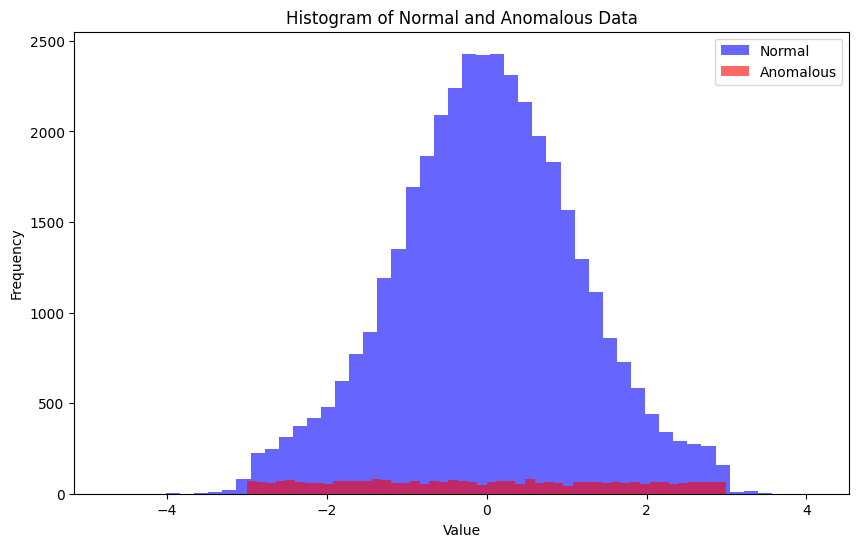

In [38]:
# 정상 데이터와 이상 데이터에서 일부 샘플만 선택하여 히스토그램 작성
normal_values = train_data.numpy().flatten()
anomalous_values = test_data[test_labels == 1].numpy().flatten()

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(normal_values, bins=50, alpha=0.6, color='blue', label='Normal')
plt.hist(anomalous_values, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Normal and Anomalous Data')
plt.legend()
plt.show()


In [21]:
# DDPM 모델 초기화
unet_config = {
    "params": {
        "image_size": 32,
        "in_channels": 1,
        "model_channels": 32,
        "out_channels": 1,
        "num_res_blocks": 2,
        "attention_resolutions": [16, 8],
        "dropout": 0.1,
        "channel_mult": (2, 4, 8),
        "num_heads": 4,
    }
}

ddpm = DDPM(unet_config=unet_config)
optimizer = ddpm.configure_optimizers()

# DDPM 학습
num_epochs = 10
ddpm.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        x = batch[0].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        optimizer.zero_grad()
        loss, _ = ddpm(x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.9831
Epoch 2/10, Loss: 0.8904
Epoch 3/10, Loss: 0.8334
Epoch 4/10, Loss: 0.7647
Epoch 5/10, Loss: 0.7008
Epoch 6/10, Loss: 0.6601
Epoch 7/10, Loss: 0.6253
Epoch 8/10, Loss: 0.6186
Epoch 9/10, Loss: 0.6029
Epoch 10/10, Loss: 0.5771


In [33]:
threshold = 0.5

<ipython-input-34-ec5b5792ebab>:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


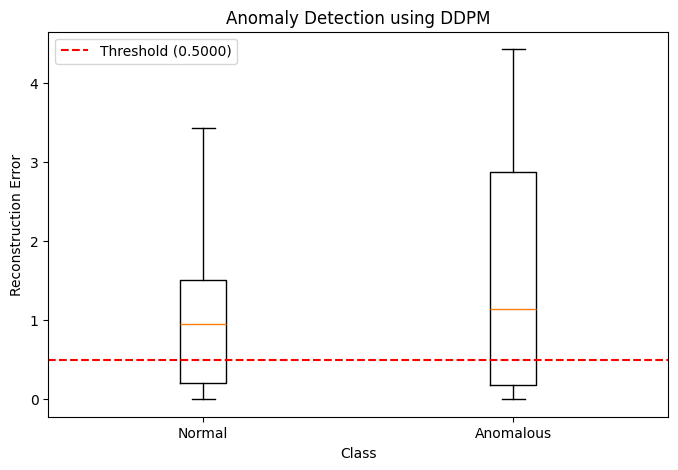

Precision: 0.1636, Recall: 0.6300, F1 Score: 0.2598


In [34]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# DDPM 평가 모드
ddpm.eval()
anomaly_scores = []
y_true = []

# 데이터셋에서 이상 탐지 수행
with torch.no_grad():
    for batch in test_loader:
        x, labels = batch
        x = x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        t = torch.randint(0, ddpm.num_timesteps, (x.shape[0],), device=x.device).long()
        x_noisy = ddpm.q_sample(x, t)
        x_reconstructed = ddpm.p_sample(x_noisy, t)

        loss = torch.nn.functional.mse_loss(x, x_reconstructed, reduction='none').mean(dim=[1, 2])
        anomaly_scores.extend(loss.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 박스플롯을 이용한 시각화
plt.figure(figsize=(8, 5))
plt.boxplot([
    [anomaly_scores[i] for i in range(len(y_true)) if y_true[i] == 0],  # 정상 데이터
    [anomaly_scores[i] for i in range(len(y_true)) if y_true[i] == 1]   # 이상 데이터
], labels=['Normal', 'Anomalous'])

# 임계값 표시 (빨간색 수평선)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')

plt.xlabel('Class')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection using DDPM')
plt.legend()
plt.show()

# 정밀도, 재현율, F1 점수 계산
predictions = [1 if score > threshold else 0 for score in anomaly_scores]
precision, recall, f1, _ = precision_recall_fscore_support(y_true, predictions, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

